# SP500 Market Data


### Contents
**Step 0. Initialize notebook**     
**Step 1. Data Import**    
**Step 2. Market Cycles**  
**Step 3a. Join & Transform**  
**Step 3b. Analyze and Observe**
**Step 4. Correlate & Heatmap**  
**Step 5. Save the ML data frame**

# Step 0. Initialize Notebook 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta as td
import seaborn as sns
import quandl

%run fmget
%run fmtransforms
%run fmplot
%run fmcycle

# Step 1. Data Import


<table>
    <caption><center><strong>Table 1. Data and Sources </strong></center></caption>
    <tr>
     <td width="10%" style="text-align:left;vertical-align:center;" ><strong>Data</strong></td>
     <td width="20%" style="text-align:left;vertical-align:center;" ><strong>Source</strong></td>
     <td width="10%" style="text-align:left;vertical-align:center;" ><strong>Frequency</strong></td>
     <td width="10%" style="text-align:left;vertical-align:center;" ><strong>Start Date</strong></td>
    </tr>
     <tr>
        <td style="text-align:left;vertical-align:top;" >
          S&P 500
        </td>
        <td style="text-align:left;vertical-align:top;" >
          Yahoo Finance ^GSPC
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Daily
        </td>
       <td style="text-align:left;vertical-align:top;" >
          1927-12-30
        </td>
      </tr>
     <tr>
        <td style="text-align:left;vertical-align:top;" >
          Recessions
        </td>
        <td style="text-align:left;vertical-align:top;" >
          Wikepedia (entered into a Pyquant callable function), pyquant.get_ressions()
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Recessions function updated when there is recessions (usually many years between recessions)
        </td>
       <td style="text-align:left;vertical-align:top;" >
          1950
        </td>
      </tr>
     <tr>
     <td style="text-align:left;vertical-align:top;" >
         Yield Curve 10 year (long term) fixed rate vs. 3 month (short term) rates.
      </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, T10Y3M
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Daily
        </td>
       <td style="text-align:left;vertical-align:top;" >
          1982-1-4
        </td>
      </tr>
         <tr>
     <td style="text-align:left;vertical-align:top;" >
         Gross Domestic Product 
      </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, GDP
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Quarterly
        </td>
        <td style="text-align:left;vertical-align:top;" >
          1947-1-1
        </td>
      </tr>
     <tr>
       <td style="text-align:left;vertical-align:top;" >
         Unemployment Rate 
        </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, UNRATE
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Monthly
        </td>
          <td style="text-align:left;vertical-align:top;" >
          1948-1-1
        </td>
        </tr>
         <tr>
       <td style="text-align:left;vertical-align:top;" >
         Consumer Price Index 
        </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis, CPIAUCSL, 1982to1984 100% 
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Monthly
        </td>
         <td style="text-align:left;vertical-align:top;" >
          1947-1-1
        </td>
        </tr>
        <tr>
       <td style="text-align:left;vertical-align:top;" >
         Consumer Sentiment
        </td>
        <td style="text-align:left;vertical-align:top;" >
          FRED St. Louis,UMCSENT 
         </td>
        <td style="text-align:left;vertical-align:top;" >
          Monthly
        </td>
         <td style="text-align:left;vertical-align:top;" >
         1953-2-1
        </td>
      </tr>
</table>

In [3]:
# files with current set of data

%run fmget

# get recessions
recessions = get_recessions()

# Data files

sp500_file = './data/GSPC_1950-1-3_to_2020-10-5.csv'
sppe_file='./data/sppe_1950-2-1_to_2020-10-1.csv'
t10y3m_file='./data/T10Y3M_1982-1-4_to_2020-10-5.csv'
gdp_file='./data/GDP_1947-1-1_to_2020-4-1.csv'
unrate_file='./data/UNRATE_1948-1-1_to_2020-9-1.csv'
cpiaucsl_file='./data/CPIAUCSL_1947-1-1_to_2020-8-1.csv'
umcsent_file='./data/UMCSENT_1953-2-1_to_2020-8-1.csv'
    
df_sp500 = pd.read_csv(sp500_file,index_col=0,parse_dates=True)
df_sppe = pd.read_csv(sppe_file,index_col=0,parse_dates=True)
df_t10y3m =pd.read_csv(t10y3m_file,index_col=0,parse_dates=True)
df_gdp = pd.read_csv(gdp_file,index_col=0,header=0,parse_dates=True)
df_unrate = pd.read_csv(unrate_file,index_col=0,header=0,parse_dates=True)
df_cpiaucsl = pd.read_csv(cpiaucsl_file,index_col=0,header=0,parse_dates=True)
df_umcsent = pd.read_csv(umcsent_file,index_col=0,header=0,parse_dates=True)

# update data and append, if update_data == True    
update_data=False

if update_data==True:
    print('today =',dt.datetime.today())
    start=dt.datetime(2020,8,1)  # update data start
    end=dt.datetime(2020,10,6)   # update data end

    # Quandle API key
    quandle_api_key_file = "quandl_api_key_file"
    f = open(quandle_api_key_file,'r')
    quandl_api_key=f.read().strip()
    f.close

    # Fred API key
    fred_api_key_file = "fred_api_key_file"
    f = open(fred_api_key_file,'r')
    fred_api_key=f.read().strip()
    f.close

    df_sp500=yahoo_getappend('^GSPC',start,end,df=df_sp500,save=True,savedir='./data')
    df_sppe=quandl_sppe_getappend(df_sppe_daily,df_sp500,quandl_api_key, start,end,save=True, savedir='./data')
    df_t10y3m=fred_getappend('T10Y3M',start,end,df=df_t10y3m,API_KEY_FRED=fred_api_key,save=True,savedir='./data')
    df_gdp=fred_getappend('GDP',start,end,df=df_gdp,API_KEY_FRED=fred_api_key,save=True,savedir='./data')
    df_unrate=fred_getappend('UNRATE',start,end,df=df_unrate,API_KEY_FRED=fred_api_key,save=True,savedir='./data')
    df_cpiaucsl=fred_getappend('CPIAUCSL',start,end,df=df_cpiaucsl,API_KEY_FRED=fred_api_key,save=True,savedir='./data')
    df_umcsent=fred_getappend('UMCSENT',start,end,df=df_umcsent,API_KEY_FRED=fred_api_key,save=True,savedir='./data')


    
display(df_sp500.tail(2))
display(df_t10y3m.tail(2))
display(df_sppe.tail(2))
display(df_gdp.tail(2))
display(df_unrate.tail(2))
display(df_cpiaucsl.tail(2))
display(df_umcsent.tail(2))
    
# today = 2020-10-06 12:24:59.975927
#2020-08-01 00:00:00 2020-10-06 00:00:00
#[*********************100%***********************]  1 of 1 completed
#df to csv, filename =  ./data/GSPC_1950-1-3_to_2020-10-5.csv
#df to csv, filename =  ./data/sp500_pe_daily_1950-1-3_to_2020-10-5.csv
#df to csv, filename =  ./data/T10Y3M_1982-1-4_to_2020-10-5.csv
#df to csv, filename =  ./data/GDP_1947-1-1_to_2020-4-1.csv
#df to csv, filename =  ./data/UNRATE_1948-1-1_to_2020-9-1.csv
#df to csv, filename =  ./data/CPIAUCSL_1947-1-1_to_2020-8-1.csv
#df to csv, filename =  ./data/UMCSENT_1953-2-1_to_2020-8-1.csv

,Close,High,Low,Open,Volume,Adj Close
Date,,,,,,
2020-10-02,3348.419922,3369.100098,3323.689941,3338.939941,3.961550e+09,3348.419922
2020-10-05,3408.600098,3409.570068,3367.270020,3367.270020,3.686920e+09,3408.600098


,T10Y3M
index,
2020-10-02,0.61
2020-10-05,0.68


,PE,Close,Earnings
Date,,,
2020-09-30,28.91,3363.000000,116.326531
2020-10-01,29.06,3380.800049,116.338611


,GDP
index,
2020-01-01,21561.139
2020-04-01,19408.759


,UNRATE
index,
2020-08-01,8.4
2020-09-01,7.9


,CPIAUCSL
index,
2020-07-01,258.723
2020-08-01,259.681


,UMCSENT
index,
2020-07-01,72.5
2020-08-01,74.1


# Step 2 Market Cycles

In [4]:
#Market Cycles

%run fmtransforms
%run fmplot
%run fmcycle

compute=0   # if compute is 1 then compute new market cycles, else load from saved file

f_dfmc="./data/GSPC_dfmc2020.5_1950_2020-10-5.csv"
f_dfmcs="./data/GSPC_dfmcs2020.5_1950_2020-10-5.csv"

mcycledown=20
mcycleup=20.5

#string = get_market_cycles()
print('today =',dt.datetime.today())
df_mc,df_mcsummary=fmcycles(df=df_sp500,symbol='GSPC',compute=compute, mc_filename=f_dfmc, mcs_filename=f_dfmcs,
                 mcdown_p=mcycledown,mcup_p=mcycleup,savedir="./data")

display(df_mc.tail(2))

#today = 2020-10-07 
#compute ==0, read from file ...
#  save dfmc file:  ./data/GSPC_dfmc2020.5_1950_2020-10-5.csv
#  save dfmcs file: ./data/GSPC_dfmcs2020.5_1950_2020-10-5.csv
# mcdown = 20 mcup = 20.5

today = 2020-10-31 10:07:04.261755
compute ==0, read from file ...
  dfmc filename =  ./data/GSPC_dfmc2020.5_1950_2020-10-5.csv
  dfmcs filename =  ./data/GSPC_dfmcs2020.5_1950_2020-10-5.csv
mcdown = 20 mcup = 20.5


,Close,High,Low,Open,Volume,Adj Close,mkt,mcupm,mcnr,mucdown,mdcup
Date,,,,,,,,,,,
2020-10-02,3348.419922,3369.100098,3323.689941,3338.939941,3.961550e+09,3348.419922,1,1,0.496567,0.064907,0.0
2020-10-05,3408.600098,3409.570068,3367.270020,3367.270020,3.686920e+09,3408.600098,1,1,0.523465,0.048100,0.0


# Step 3a Transform and Join

In [13]:
%run fmtransforms

df_ml=pd.DataFrame()

# Join PE, Earnings and Market Cycles 
# Drop Adj Close, does not make sense for S&P
# Compute Earnings percent return
df_sppe=period_percent_change(df_sppe,'Earnings',new_variable_name = 'Earnings_mom')
df_ml=fmjoinff(df_mc,df_sppe[['PE','Earnings','Earnings_mom']],verbose=False,dropnas=True).drop(['Adj Close'],axis=1)


# Yield Curve, T10Y3M, 10 Year Treasury - 3 Month Treasury
df_ml=fmjoinff(df_ml,df_t10y3m,verbose=False,dropnas=True)

# GDP
df_gdp = gdprecession(df_gdp,'GDP') # adds gdg_qoq, recession1q, recession2q
df_ml=fmjoinff(df_ml,df_gdp,verbose=False,dropnas=True)

# Unemployment
df_unrate=period_percent_change(df_unrate,'UNRATE',new_variable_name='unrate_pchange')
df_ml=fmjoinff(df_ml,df_unrate,verbose=False,dropnas=True)

# Consumer price index
df_cpi=period_percent_change(df_cpiaucsl,'CPIAUCSL',new_variable_name='cpimom')
df_ml=fmjoinff(df_ml,df_cpi[['CPIAUCSL','cpimom']],verbose=False,dropnas=True)

# Consumter Sentiment
df_umcsent=period_percent_change(df_umcsent,'UMCSENT',new_variable_name='umcsent_pchange')
df_ml=fmjoinff(df_ml,df_umcsent,verbose=False,dropnas=True)


# Simple Moving Averages
df_ml=dfsma(df_ml,'Close',windows=[20,50,200])

# Normalized mavgs
#   1-day (today / yesterday .... sma5 = 5-day smavg( today / yesterday ) .... )
df_ml=dfnma(df_ml,['Close','Volume'],windows=[1,5,10,15,20,30,50,200])

# Relative 200-day moving average
# scale of 0 to 1
df_ml=dfrma(df_ml,'Close_sma50','Close_sma200',varname='rma_sma50_sma200')
df_ml=dfrma(df_ml,'Close_sma20','Close_sma50',varname='rma_sma20_sma50')

# ADX
df_ml=dfadx(df_ml,'Close','High','Low',window=50)

# Volatility ... Log Return Std Dev, and Velocity
df_ml=dflogretstd(df_ml,'Close',windows=[25,63,126])
df_ml=dfvelocity(df_ml,'Close_lrstd25',windows=[5])
df_ml=dfvelocity(df_ml,'Close_lrstd63',windows=[5])
df_ml=dfvelocity(df_ml,'Close_lrstd126',windows=[5])


print(df_ml.columns)


display(df_ml.tail(3))

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'mkt', 'mcupm', 'mcnr',
       'mucdown', 'mdcup', 'PE', 'Earnings', 'Earnings_mom', 'T10Y3M', 'GDP',
       'gdp_qoq', 'recession1q', 'recession2q', 'UNRATE', 'unrate_pchange',
       'CPIAUCSL', 'cpimom', 'UMCSENT', 'umcsent_pchange', 'Close_sma20',
       'Close_sma50', 'Close_sma200', 'Close_nma1', 'Volume_nma1',
       'Close_nma5', 'Volume_nma5', 'Close_nma10', 'Volume_nma10',
       'Close_nma15', 'Volume_nma15', 'Close_nma20', 'Volume_nma20',
       'Close_nma30', 'Volume_nma30', 'Close_nma50', 'Volume_nma50',
       'Close_nma200', 'Volume_nma200', 'rma_sma50_sma200', 'rma_sma20_sma50',
       'PDI50', 'NDI50', 'ADX', 'Close_lrstd25', 'Close_lrstd63',
       'Close_lrstd126', 'Close_lrstd25_avgvel5', 'Close_lrstd63_avgvel5',
       'Close_lrstd126_avgvel5'],
      dtype='object')


,Close,High,Low,Open,Volume,mkt,mcupm,mcnr,mucdown,mdcup,...,rma_sma20_sma50,PDI50,NDI50,ADX,Close_lrstd25,Close_lrstd63,Close_lrstd126,Close_lrstd25_avgvel5,Close_lrstd63_avgvel5,Close_lrstd126_avgvel5
2020-10-01,3380.800049,3397.179932,3361.389893,3385.870117,4.070530e+09,1.0,1.0,0.511040,0.055864,0.0,...,-0.005419,24.520203,23.428824,14.045695,0.014455,0.010507,0.014129,0.000126,-0.000007,-0.000378
2020-10-02,3348.419922,3369.100098,3323.689941,3338.939941,3.961550e+09,1.0,1.0,0.496567,0.064907,0.0,...,-0.007230,23.566008,25.085963,13.422419,0.014451,0.010558,0.014163,0.000044,0.000001,-0.000365
2020-10-05,3408.600098,3409.570068,3367.270020,3367.270020,3.686920e+09,1.0,1.0,0.523465,0.048100,0.0,...,-0.008623,25.337339,24.043249,12.808537,0.014977,0.010737,0.013950,0.000100,0.000005,-0.000304


# Step 3b Analyze and Observe

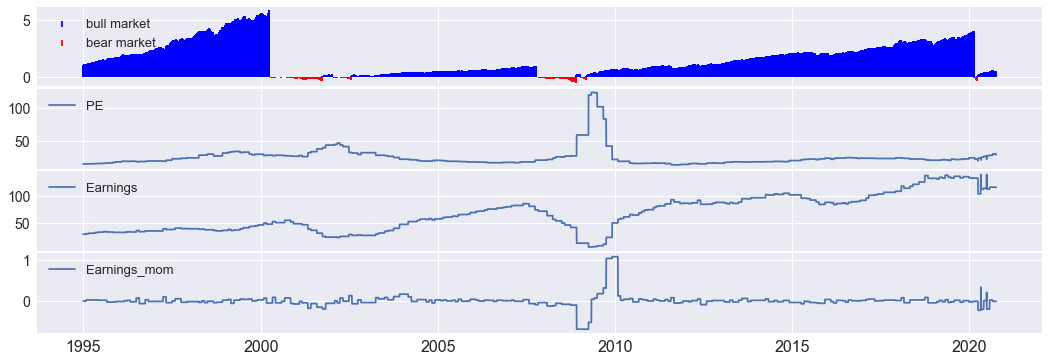

In [21]:
# PE Data

%run fmtransforms
%run fmplot

s=dt.datetime(1950,1,1)
e=dt.datetime(2010,1,1)

#s=dt.datetime(2007,1,1)
#e=dt.datetime(2010,1,1)

s=dt.datetime(1995,1,1)
e=dt.datetime(2020,10,5)

fmplot(df_ml,variables=['mcnr','PE','Earnings','Earnings_mom'],plottypes=['mktcycle','line','line','line'],
       sharex=True, hspace=0.03, startdate=s,enddate=e, figsize=[18,6],  
       xtick_labelsize=16, ytick_labelsize=14,legend_fontsize=13 )

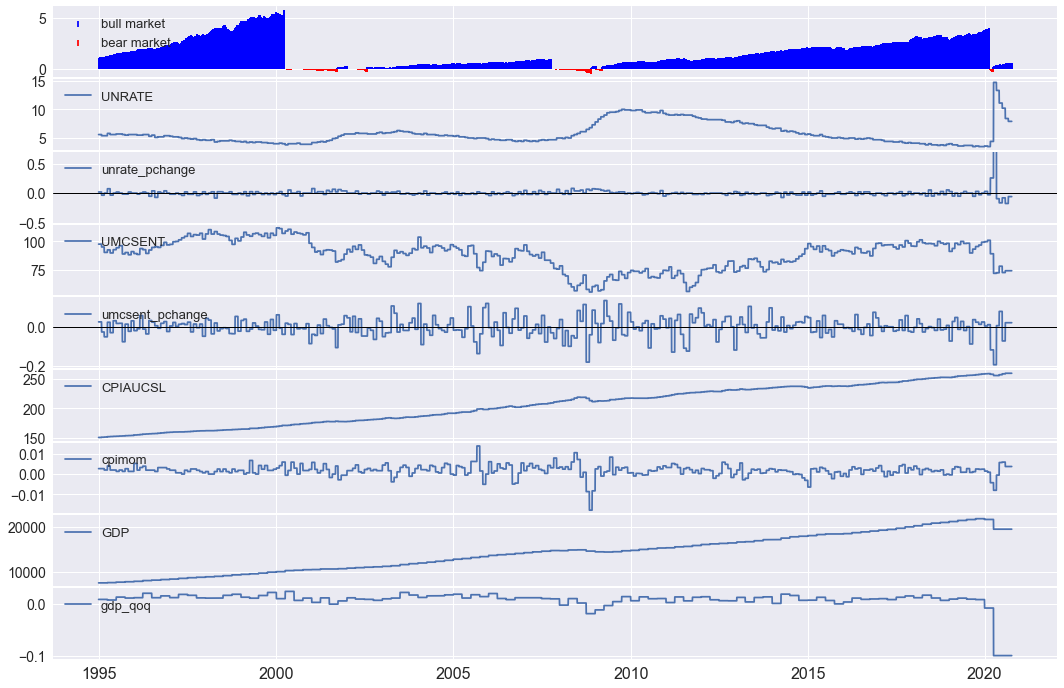

In [25]:
s=dt.datetime(1950,1,1)
e=dt.datetime(2020,10,5)

s=dt.datetime(1995,1,1)
e=dt.datetime(2020,10,5)

fmplot(df_ml,variables=['mcnr','UNRATE','unrate_pchange','UMCSENT','umcsent_pchange','CPIAUCSL' ,'cpimom','GDP','gdp_qoq'],
       plottypes=['mktcycle','','','','','','','',''],
       hspace=.03, sharex=True,ylims=['','',(-0.5,0.7),'','','','','',''],hlines=['','',0,'',0,'','','',''],
      startdate=s,enddate=e, figsize=[18,12],xtick_labelsize=16, ytick_labelsize=14,legend_fontsize=13 )

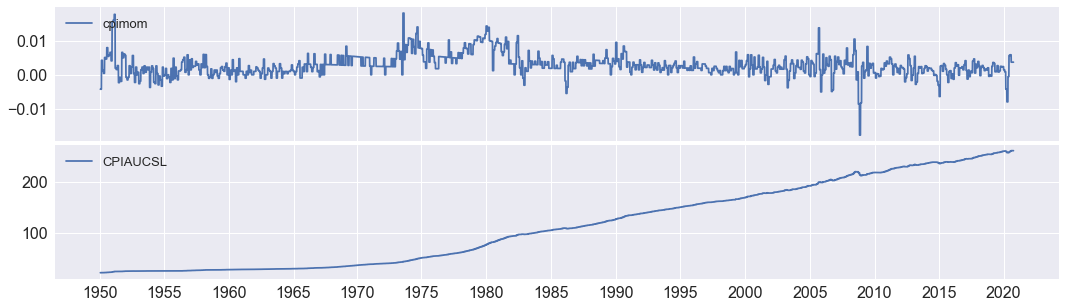

In [15]:
# Consumer Price Index

%run fmtransforms
%run fmplot

s=dt.datetime(1980,1,1)
e=dt.datetime(1983,1,1)

#s=dt.datetime(1950,1,1)
#e=dt.datetime(2020,8,24)

s=dt.datetime(1950,1,1)
e=dt.datetime(2020,10,5)

fmplot(df_ml,variables=['cpimom','CPIAUCSL'], startdate=s,enddate=e,hspace=.025,
       xtick_labelsize=16, ytick_labelsize=16,sharex=True,figsize=[18,5],legend_fontsize=13)

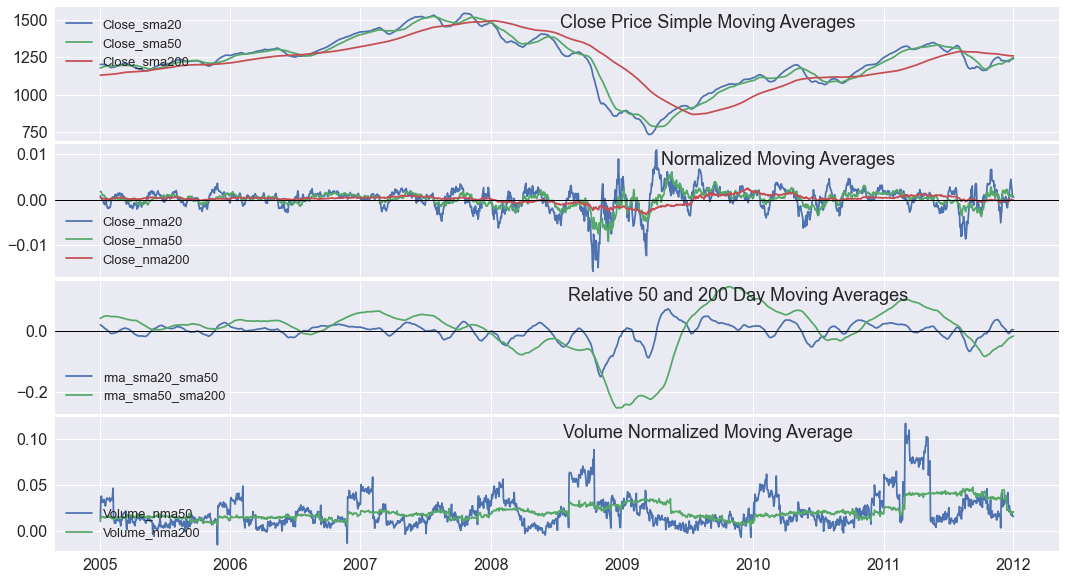

In [36]:
# Momentum Moving Averages

%run fmplot
startdate = dt.datetime(1976,6,1)
enddate = dt.datetime(2000,8,1)
startdate = dt.datetime(2005,1,1)
enddate = dt.datetime(2012,1,1)
#startdate = dt.datetime(2020,3,1)
#enddate = dt.datetime(2020,4,14)


titles=['Close Price Simple Moving Averages','Normalized Moving Averages','Relative 50 and 200 Day Moving Averages',
        'Volume Normalized Moving Average']
variables=[ ['Close_sma20', 'Close_sma50', 'Close_sma200'], [ 'Close_nma20', 'Close_nma50','Close_nma200'],
           ['rma_sma20_sma50' ,  'rma_sma50_sma200'],
           ['Volume_nma50','Volume_nma200']]

fmplot(df_ml,variables,titles=titles,startdate=startdate,
          enddate=enddate, llocs=['upper left','lower left','lower left','lower left','upper left'], 
          title_fontsize=18, titlein=True, hlines=['',0,0,''],titlexy=[(0.65,0.8),(0.72,0.8),(0.68,0.8),(0.65,0.8)],
          hspace=.025, sharex=True, xtick_labelsize=16, ytick_labelsize=16,legend_fontsize=13, figsize=(18,10))

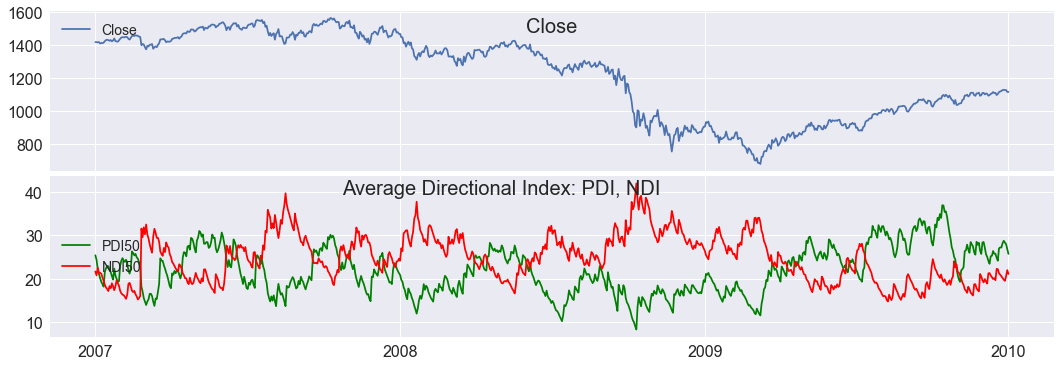

In [18]:
# ADX
startdate = dt.datetime(1976,6,1)
enddate = dt.datetime(2000,8,1)
startdate = dt.datetime(2007,1,1)
enddate = dt.datetime(2010,1,1)
#startdate = dt.datetime(2020,1,1)
#enddate = dt.datetime(2020,4,14)

titles=['Close', 'Average Directional Index: PDI, NDI']
fmplot(df_ml,['Close',['PDI50','NDI50']],titles=titles,startdate=startdate, 
          enddate=enddate,hspace=.03, sharex=True,titlein = True, titlexy=[(0.5,0.83),(0.45,0.85)],
           llocs=['upper left','center left','center left'],
          linecolors=['',['g','r','b']], xtick_labelsize=16, ytick_labelsize=16, 
          legend_fontsize=14,title_fontsize=20, figsize=(18,6))

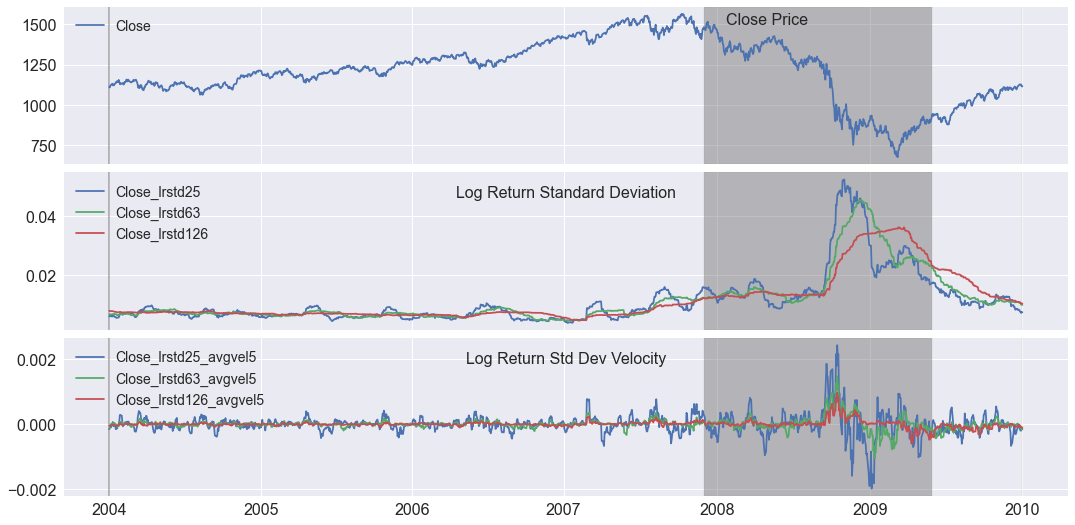

In [16]:
# Volatility
%run fmplot
#startdate = dt.datetime(1950,1,1)
#startdate = dt.datetime(1999,1,1)
#enddate = dt.datetime(2002,1,1)
#enddate = dt.datetime(2020,4,1)
startdate = dt.datetime(2004,1,1)
enddate = dt.datetime(2010,1,1)
#startdate = dt.datetime(2019,1,1)
#enddate = dt.datetime(2020,4,14)


fmplot(df_ml,['Close',['Close_lrstd25','Close_lrstd63','Close_lrstd126'],['Close_lrstd25_avgvel5','Close_lrstd63_avgvel5','Close_lrstd126_avgvel5']],
          titles=[ 'Close Price','Log Return Standard Deviation','Log Return Std Dev Velocity'],startdate=startdate, 
          enddate=enddate, llocs=['upper left', 'upper left','upper left','upper left'],titlein=True, title_fontsize=16, hspace=0.05,fb=recessions,
          titlexy=[(0.7,0.85),'',''], sharex=True,
          xtick_labelsize=16, ytick_labelsize=16,legend_fontsize=14, figsize=(18,9))

### Comments and Observations
* **CPIAUCSL, cpimom** - No obvious easily understood relationship with CPIAUCSL, also shows 0.11 correlation with market
* **GDP, gdpqoq** - similar situation with GDP, though shows 0.11 correlation with market

# Step 4 Correlate and Heatmap 

In [283]:
df_ml.drop(['Close_sma20','Close_sma50','Close_sma200'],axis=1,inplace=True)
tmp_remove_cols=['Close','High','Low','Open','Volume','Earnings']
corr_matrix = df_ml.drop(columns=tmp_remove_cols,axis=1).corr()
print(corr_matrix.columns.values)
print(corr_matrix['mkt'].sort_values( ascending = False))

['mkt' 'mcupm' 'mcnr' 'mucdown' 'mdcup' 'PE' 'T10Y3M' 'GDP' 'gdp_qoq'
 'recession1q' 'recession2q' 'UNRATE' 'UNRATE_avgvel3' 'CPIAUCSL' 'cpimom'
 'UMCSENT' 'UMCSENT_avgvel3' 'Close_nma1' 'Volume_nma1' 'Close_nma5'
 'Volume_nma5' 'Close_nma10' 'Volume_nma10' 'Close_nma15' 'Volume_nma15'
 'Close_nma20' 'Volume_nma20' 'Close_nma30' 'Volume_nma30' 'Close_nma50'
 'Volume_nma50' 'Close_nma200' 'Volume_nma200' 'rma_sma50_sma200'
 'rma_sma20_sma50' 'PDI50' 'NDI50' 'ADX' 'Close_lrstd25' 'Close_lrstd63'
 'Close_lrstd126' 'Close_lrstd25_avgvel5' 'Close_lrstd63_avgvel5'
 'Close_lrstd126_avgvel5']
mkt                       1.000000
mcnr                      0.407377
Close_nma200              0.384183
Close_nma50               0.365427
Close_nma30               0.336877
rma_sma50_sma200          0.336456
rma_sma20_sma50           0.319561
mcupm                     0.303942
Close_nma20               0.297762
Close_nma15               0.272517
UMCSENT_avgvel3           0.256848
Close_nma10            

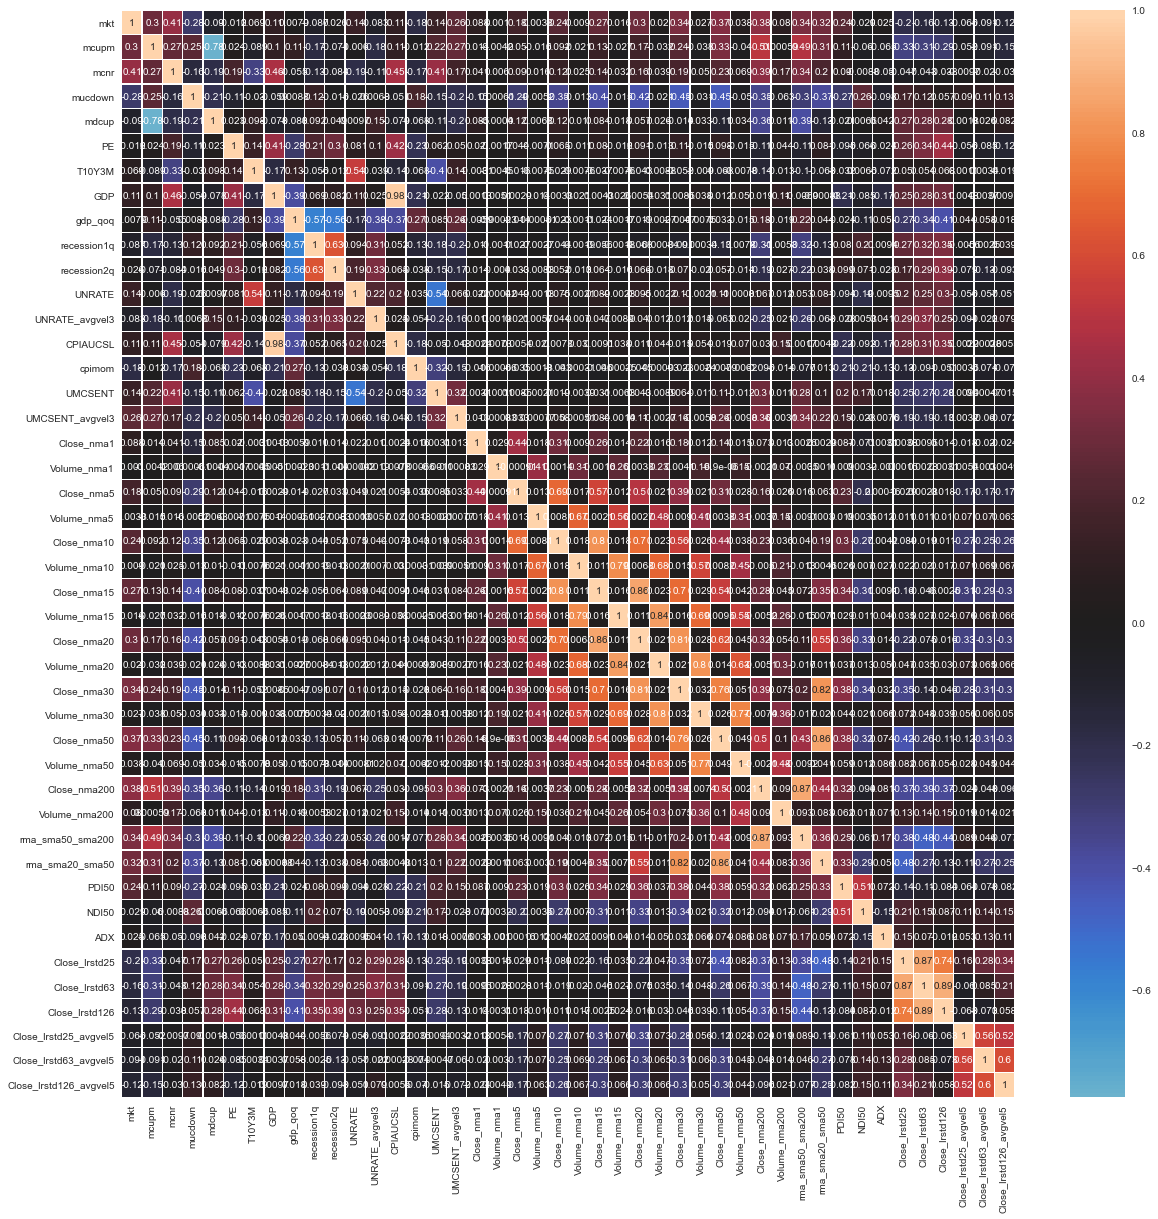

In [284]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix, center=0, annot=True, linewidths=.3, ax=ax)
plt.show()

In [285]:
# Correlate variables with shifts of the target variable ("mkt"). 
# Save the correlations for each variable in a dictionary, 
# where each key points at a list of the sweep
# from 1 day shift to n = 200.

var_list=df_ml.columns
corr_vars = ['corr_'+v for v in var_list]  # name of each = corr_"variable" key for the corr_dict 
corr_dict={c : [] for c in corr_vars}     # dictionary of correlations key = "corr_variablename"

total_corr=[]

# iterate over shifted target variable
for k in range(1, 201):
    mkt_n = 'mkt_' + str(k)              # shifted variable name
    df_ml[mkt_n]=df_ml['mkt'].shift(k)   # shifted variable 
    corr_matrix = df_ml.corr()           # new correlation matrix
    print(k,end = '.. ')
    
    # Iterate through dictionary keys and corresponding variables
    for c,v in zip(corr_dict,var_list):
        corr_dict[str(c)].append(corr_matrix[v][mkt_n])  # append correlation to list according to variable key
    
    df_ml.drop(mkt_n, axis=1, inplace=True)  # drop the shifted target variable
        
    # add up the total correlations ... approximationdoes not factor in negative cross contributions
    total_corr.append(corr_matrix[mkt_n].abs().sum()-1)
    

corr_dict.update({'total_corr' : total_corr})
    

#for key in corr_dict:
#    print('corr_dict key =',key)


1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 50.. 51.. 52.. 53.. 54.. 55.. 56.. 57.. 58.. 59.. 60.. 61.. 62.. 63.. 64.. 65.. 66.. 67.. 68.. 69.. 70.. 71.. 72.. 73.. 74.. 75.. 76.. 77.. 78.. 79.. 80.. 81.. 82.. 83.. 84.. 85.. 86.. 87.. 88.. 89.. 90.. 91.. 92.. 93.. 94.. 95.. 96.. 97.. 98.. 99.. 100.. 101.. 102.. 103.. 104.. 105.. 106.. 107.. 108.. 109.. 110.. 111.. 112.. 113.. 114.. 115.. 116.. 117.. 118.. 119.. 120.. 121.. 122.. 123.. 124.. 125.. 126.. 127.. 128.. 129.. 130.. 131.. 132.. 133.. 134.. 135.. 136.. 137.. 138.. 139.. 140.. 141.. 142.. 143.. 144.. 145.. 146.. 147.. 148.. 149.. 150.. 151.. 152.. 153.. 154.. 155.. 156.. 157.. 158.. 159.. 160.. 161.. 162.. 163.. 164.. 165.. 166.. 167.. 168.. 169.. 170.. 171.. 172.. 173.. 174.. 175.. 176.. 177.. 178.. 179.. 180.. 181.. 182.. 183.. 184.. 185.

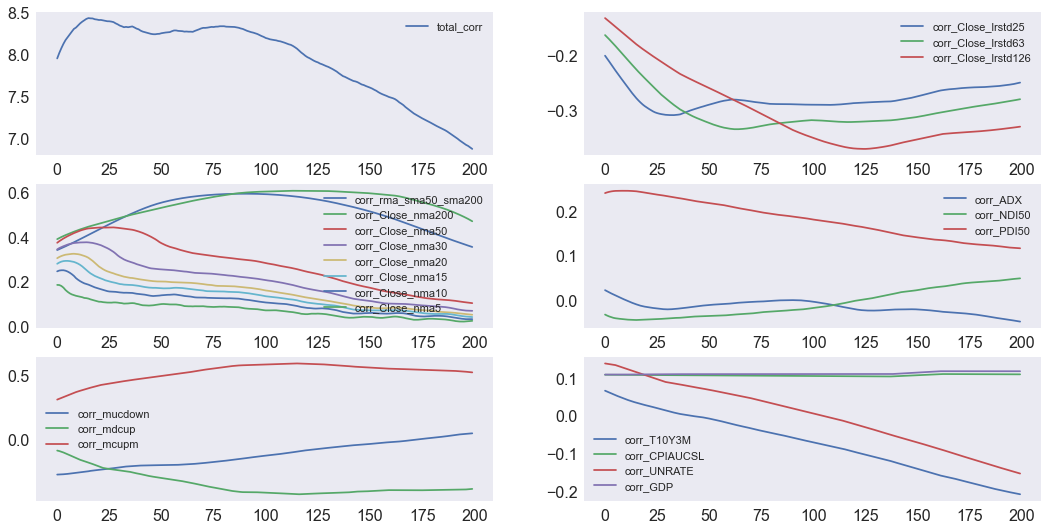

In [286]:
# Look at correlations with shifts of the target variable
 

# k by k plot   

fig,ax = plt.subplots(nrows=3,ncols=2,figsize=[18,9])

corr_list=[ 
       [['total_corr'] , ['corr_Close_lrstd25','corr_Close_lrstd63','corr_Close_lrstd126']],
       [['corr_rma_sma50_sma200','corr_Close_nma200','corr_Close_nma50','corr_Close_nma30','corr_Close_nma20','corr_Close_nma15','corr_Close_nma10','corr_Close_nma5'], ['corr_ADX','corr_NDI50','corr_PDI50']],
       [['corr_mucdown','corr_mdcup','corr_mcupm'], ['corr_T10Y3M','corr_CPIAUCSL','corr_UNRATE','corr_GDP']],    
     ]


for k2 in range(0,3):
    for k1 in range(0,2): 
        for key in corr_list[k2][k1]:
            ax[k2,k1].plot(corr_dict[str(key)], label=key)
        ax[k2,k1].legend(loc='upper right')
        ax[k2,k1].grid()
        ax[k2,k1].legend(fontsize=11)
        ax[k2,k1].tick_params( labelsize=16)

    
plt.show() 

# 5. Save the ML Dataframe

In [287]:
# Save the df_ml dataframe

today = dt.datetime.today()
startDate=df_ml.index[0]
endDate=df_ml.index[df_ml.index.size-1]
filename='./data/df_ml_'+str(today.year)+str(today.month)+str(today.day)+'_'+str(startDate.year)+str(startDate.month)+\
          str(startDate.day)+'_to_'+str(endDate.year)+str(endDate.month)+str(endDate.day)+'.csv'
print('save filename =',filename)

# save the data index as a column named date 
df_ml.reset_index().rename(columns={'index':'Date'}).to_csv(filename,index=False)

save filename = ./data/df_ml_20201013_195013_to_2020105.csv
